# Listing 1
## Setting up the Super Mario Bros. environment

In [1]:
import gym
from nes_py.wrappers import JoypadSpace # this wrapper module will make the action-space smaller by combining actions together
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) # wraps the environment's action space to be 12 discrete actions
done = True
for step in range(2500): # tests the environment by taking random actions
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

# Listing 2
## Downsample state and convert to grayscale

In [2]:
import matplotlib.pyplot as plt
from skimage.transform import resize # the scikit-image library has an image-resizing function built in
import numpy as np

def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2) # to convert to grayscale, we simply take the maximum values across the channel dimension for good contrast
    else:
        return resize(obs, new_size, anti_aliasing=True)

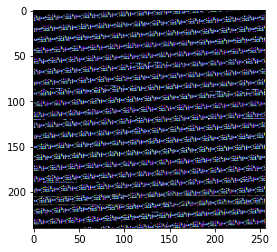

In [3]:
plt.imshow(env.render("rgb_array"))

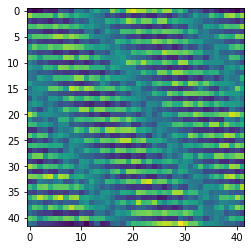

In [4]:
plt.imshow(downscale_obs(env.render("rgb_array")))

# Listing 3
## Preparing the states

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state): # downscales state and converts to grayscale, converts to a PyTorch tensor and finally adds a batch dimension
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def prepare_multi_state(state1, state2): # given an existing 3-frame state1 and a new single frame 2, adds the latest frame to the queue
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1

def prepare_initial_state(state, N=3): # creates a state with three copies of the same frame and adds a batch dimension
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N, 1, 1))
    return tmp.unsqueeze(dim=0)

# Listing 4
## The policy function

In [6]:
def policy(qvalues, eps=None): # the policy function takes a vector of action values and an epsilon parameter
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0, high=7, size=(1, ))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) # if eps is not provided, uses a softmax policy. We sample from the softmax using the multinomial function

# Listing 5
## Experience replay

In [7]:
from random import shuffle

class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N # N is the maximum size of the memory list
        self.batch_size = batch_size # batch_size is the number of samples to generate from the memory with the get_batch() method
        self.memory = [] 
        self.counter = 0
    
    def add_memory(self, state1, action, reward, state2):
        self.counter += 1
        if self.counter % 500 == 0: # every 500 iterations of adding a memory, shuffles the memory list to promote a more random sample
            self.shuffle_memory()
        if len(self.memory) < self.N: # if the memory is not full, adds to the list; otherwise replaces a random memory with the new one
            self.memory.append((state1, action, reward, state2))
        else:
            rand_index = np.random.randint(0, self.N - 1)
            self.memory[rand_index] = (state1, action, reward, state2)
    
    def shuffle_memory(self): # uses Python's built-in shuffle function to shuffle the memory list
        shuffle(self.memory)
        
    def get_batch(self): # randomly samples a mini-batch from the memory list
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        
        ind = np.random.choice(np.arange(len(self.memory)), batch_size, replace=False) # creates an array of random integers representing indices
        batch = [self.memory[i] for i in ind] # batch is a list of tuples
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch], dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch], dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

# Listing 6
## ICM components

In [8]:
class Phi(nn.Module): # Phi is the encoder network
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
    
    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) # size [1, 32, 3, 3] batch, channels, 3 x 3
        y = y.flatten(start_dim=1) # size N, 288
        return y
    
class Gnet(nn.Module): # Gnet is the inverse model
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576, 256)
        self.linear2 = nn.Linear(256, 12)
    
    def forward(self, state1, state2):
        x = torch.cat((state1, state2), dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y, dim=1)
        return y
    
class Fnet(nn.Module): # Fnet is the forward model
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300, 256)
        self.linear2 = nn.Linear(256, 288)
    
    def forward(self, state, action):
        action_ = torch.zeros(action.shape[0], 12) # the actions are stored as integers in the replay memory, so we convert to a one-hot encoded vector
        indices = torch.stack((torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat((state, action_), dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

# Listing 7
## Deep Q-network

In [9]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.linear1 = nn.Linear(288, 100)
        self.linear2 = nn.Linear(100, 12)
    
    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) 
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y) # the output is of shape N x 12
        return y 

# Listing 8
## Hyperparameters and model instantiation

In [10]:
params = {
    'batch_size': 150,
    'beta': 0.2,
    'lambda': 0.1,
    'eta': 1.0,
    'gamma': 0.2,
    'max_episode_len': 100,
    'min_progress': 15,
    'action_repeats': 6,
    'frames_per_state': 3
}

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()

forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()

all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) # we can add the parameters from each model into a single list and pass that into an optimizer
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

# Listing 9
## The loss function and reset environment

In [11]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params['lambda'] * q_loss
    return loss

def reset_env(): # reset the environment and return a new initial state
    env.reset()
    state1 = prepare_initial_state(env.render('rgb_array'))
    return state1

# Listing 10
## The ICM prediction error calculation

In [12]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    state1_hat = encoder(state1) # encodes state1 and state2 using the encoder model
    state2_hat = encoder(state2)
    
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach()) # runs the forward model using the encoded states but we detach them from the graph
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    
    pred_action = inverse_model(state1_hat, state2_hat) # the inverse model returns a softmax probability distribution over actions
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, action.detach().flatten()).unsqueeze(dim=1)
    
    return forward_pred_err, inverse_pred_err

# Listing 11
## Mini-batch training using experience replay

In [13]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()
    action_batch = action_batch.view(action_batch.shape[0], 1) # we reshape these tensors to add a single dimension to be compatible with the models
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)
    
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) # runs the ICM
    i_reward = (1. / params['eta']) * forward_pred_err # scales the forward-prediction error using the eta parameter
    reward = i_reward.detach() # starts totalling up the reward; makes sure to detach the i_reward tensor
    
    if use_explicit: # the use_explicit boolean variable lets us decide whether or not to use explicit rewards in addition to the intrinsic reward
        reward += reward_batch
    
    qvals = Qmodel(state2_batch) # computes the action values for the next state
    reward += params['gamma'] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack((torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0) # since the action_batch is a tensor of integers of action indices, we convert this to a tensor of one-hot encoded vectors
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

# Listing 12
## The training loop

In [17]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env.reset()
state1 = prepare_initial_state(env.render('rgb_array'))
eps = 0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
last_x_pos = env.env.env._x_position # we need to keep track of the last x position in order to reset if there's no forward progress
ep_lengths = []
use_extrinsic = False
for i in range(epochs):
    opt.zero_grad()
    episode_length += 1
    q_val_pred = Qmodel(state1) # runs the DQN forward to get action-value predictions
    if i > switch_to_eps_greedy: # after the first 1000 epochs, switches to the epsilon-greedy policy
        action = int(policy(q_val_pred, eps))
    else:
        action = int(policy(q_val_pred))
    for j in range(params['action_repeats']): # repeats whatever action the policy says 6 times to speed up learning
        state2, e_reward_, done, info = env.step(action)
        last_x_pos = info['x_pos']
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward
        state_deque.append(prepare_state(state2))
    state2 = torch.stack(list(state_deque), dim=1) # converts the deque object into a tensor
    replay.add_memory(state1, action, e_reward, state2) # adds the single experience to the replay buffer
    e_reward = 0
    if episode_length > params['max_episode_len']: # if Mario is not making sufficient forward progress, restarts the game and tries again
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']
    if done:
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = env.env.env._x_position
        episode_length = 0
    else:
        state1 = state2
    if len(replay.memory) < params['batch_size']:
        continue
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=use_extrinsic) # gets the errors for one mini-batch of data from the replay buffer
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err) # computes the overall loss
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(), inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    loss.backward()
    opt.step()
env.close()

<ipython-input-6-3c16bf59b7f8>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) # if eps is not provided, uses a softmax policy. We sample from the softmax using the multinomial function


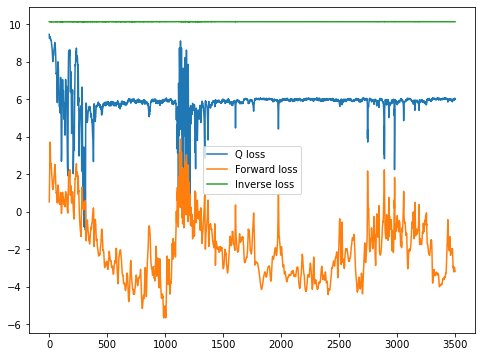

In [18]:
losses_ = np.array(losses)
plt.figure(figsize=(8, 6))
plt.plot(np.log(losses_[ : , 0]), label='Q loss')
plt.plot(np.log(losses_[ : , 1]), label='Forward loss')
plt.plot(np.log(losses_[ : , 2]), label='Inverse loss')
plt.legend()
plt.show()

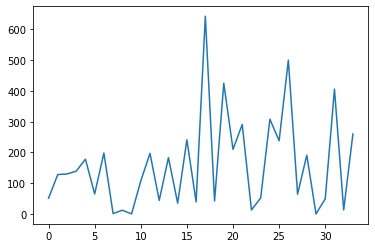

In [19]:
plt.figure()
plt.plot(np.array(ep_lengths), label='Episode length')

# Listing 13
## Testing the trained agent

In [22]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)
eps = 0.1
done = True
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(5000):
    if done:
        env.reset()
        state1 = prepare_initial_state(env.render('rgb_array'))
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred, eps))
    state2, reward, done, info = env.step(action)
    state2 = prepare_multi_state(state1, state2)
    state1 = state2
    env.render()
env.close()